In [ ]:
data_train_dir = "/content/insectos_corregido"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/insectos_corregido.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: insectos_corregido/8335452/d075s0348.jpg  
  inflating: insectos_corregido/8335452/d075s0349.jpg  
  inflating: insectos_corregido/8335452/d075s0350.jpg  
  inflating: insectos_corregido/8335452/d075s0351.jpg  
  inflating: insectos_corregido/8335452/d075s0352.jpg  
  inflating: insectos_corregido/8335452/d075s0364.jpg  
  inflating: insectos_corregido/8335452/d075s0365.jpg  
  inflating: insectos_corregido/8335452/d075s0366.jpg  
  inflating: insectos_corregido/8335452/d075s0367.jpg  
  inflating: insectos_corregido/8335452/d075s0368.jpg  
  inflating: insectos_corregido/8335452/d075s0369.jpg  
  inflating: insectos_corregido/8335452/d075s0370.jpg  
  inflating: insectos_corregido/8335452/d075s0383.jpg  
  inflating: insectos_corregido/8335452/d075s0384.jpg  
  inflating: insectos_corregido/8335452/d075s0385.jpg  
  inflating: insectos_corregido/8335452/d075s0386.jpg  
  inflating: insectos_corregido/8335452/d07

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.layers import BatchNormalization as BN
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.metrics import TopKCategoricalAccuracy

In [ ]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
target_size = (64, 32)
batch_size = 512
mode = 'categorical'
numclasses = 291

In [ ]:
train_generator = train_datagen.flow_from_directory(
    data_train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=mode,
    subset='training') # set as training data

Found 50776 images belonging to 291 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    data_train_dir, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode=mode,
    subset='validation') # set as validation data

Found 12543 images belonging to 291 classes.


In [ ]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(Activation('relu'))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(Activation('relu'))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

In [ ]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,(*target_size, 3))
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(numclasses))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 32, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 32, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 32, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 32, 32)       

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss')

In [ ]:
checkpoint_cb = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/insectos_mi_red/insectos_mi_red_weight", save_best_only=True, save_weights_only=True, monitor='val_accuracy')

In [ ]:
## OPTIM AND COMPILE
#opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy', TopKCategoricalAccuracy(k=3, name="Top_3_accuracy")])

In [ ]:
## TRAINING with DA and LRA
history=model.fit(train_generator,
                            steps_per_epoch=len(train_generator.filenames) // batch_size, 
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=[reduce_lr,checkpoint_cb],
                            verbose=1)

Epoch 1/50
99/99 [==============================] - 274s 3s/step - loss: 5.2897 - accuracy: 0.0252 - Top_3_accuracy: 0.0645 - val_loss: 13.7955 - val_accuracy: 0.0063 - val_Top_3_accuracy: 0.0164
Epoch 2/50
99/99 [==============================] - 248s 3s/step - loss: 4.3869 - accuracy: 0.0610 - Top_3_accuracy: 0.1473 - val_loss: 13.8735 - val_accuracy: 0.0127 - val_Top_3_accuracy: 0.0364
Epoch 3/50
99/99 [==============================] - 244s 2s/step - loss: 3.7877 - accuracy: 0.1039 - Top_3_accuracy: 0.2429 - val_loss: 7.1760 - val_accuracy: 0.0206 - val_Top_3_accuracy: 0.0554
Epoch 4/50
99/99 [==============================] - 244s 2s/step - loss: 3.1630 - accuracy: 0.1958 - Top_3_accuracy: 0.3903 - val_loss: 8.2209 - val_accuracy: 0.0469 - val_Top_3_accuracy: 0.1185
Epoch 5/50
99/99 [==============================] - 242s 2s/step - loss: 2.4512 - accuracy: 0.3293 - Top_3_accuracy: 0.5730 - val_loss: 8.4845 - val_accuracy: 0.0692 - val_Top_3_accuracy: 0.1638
Epoch 6/50
99/99 [=====

In [ ]:
evaluating_model = model.evaluate_generator(validation_generator, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 56s 2s/step - loss: 0.8441 - accuracy: 0.7692 - Top_3_accuracy: 0.9195


In [ ]:
import matplotlib.pyplot as plt

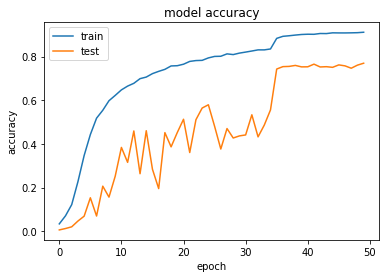

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()